In [1]:
from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
from SAnD.core.model import SAnD
from SAnD.utils.trainer import NeuralNetworkClassifier
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import smogn

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

save_directory = "rawData_Results/shuffleAll_transformerFun/e3/dbp/"
data_directory = '/data/datasets/bioz/b2b/'
training_size = 0.8
test_dict = defaultdict(dict)
subjects = next(os.walk(data_directory))[1]
x_train = None
y_train = None
x_test = None
y_test = None
x_val = None
y_val = None
init_flag = True
lag_train = None
lag_val = None
lag_test = None
for subject in subjects:
  if subject != 'Subject1':
    continue
  print(subject)
  bioz_lists = pd.read_pickle(data_directory + subject + "/list_data_time_100.pckl")
  new_bioz_list = list()
  lag_track = []
  for b in bioz_lists:
    xcorr = np.correlate(b[:,0],b[:,1], "full")
    lag_track.append(np.count_nonzero(xcorr))
    tmp_zeros = np.zeros((100-len(b),5))
    pad_b = np.concatenate((b,tmp_zeros),axis=0)
    new_bioz_list.append(pad_b)
  bioz_lists = np.asarray(new_bioz_list)  
  bioz_labels = pd.read_pickle(data_directory + subject + "/labels_100.pckl")
  bioz_labels = bioz_labels.values[:,0]
  lag_track = np.asarray(lag_track)
  num_samples = len(bioz_lists)

  indices = np.arange(num_samples)
  np.random.shuffle(indices)
  bioz_lists = bioz_lists[indices]
  bioz_labels = bioz_labels[indices]
  lag_track = lag_track[indices]
  if init_flag == True:
    init_flag = False
    x_train = bioz_lists[0:int(num_samples*training_size)]
    y_train = bioz_labels[0:int(num_samples*training_size)]
    lag_train = lag_track[0:int(num_samples*training_size)]
    x_val = x_train[int(len(x_train)*0.9):]
    y_val = y_train[int(len(y_train)*0.9):]
    lag_val = lag_train[int(len(lag_train)*0.9):]
    x_train = x_train[0:int(len(x_train)*0.9)]
    y_train = y_train[0:int(len(y_train)*0.9)]
    lag_train = lag_train[0:int(len(lag_train)*0.9)]
    x_test = bioz_lists[int(num_samples*training_size):]
    y_test = bioz_labels[int(num_samples*training_size):]
    lag_test = lag_track[int(num_samples*training_size):]
  else:
    tmp_x_train = bioz_lists[0:int(num_samples*training_size)]
    tmp_y_train = bioz_labels[0:int(num_samples*training_size)]
    tmp_lag_train = lag_track[0:int(num_samples*training_size)]
    tmp_x_val = tmp_x_train[int(len(tmp_x_train)*0.9):]
    tmp_y_val = tmp_y_train[int(len(tmp_x_train)*0.9):]
    tmp_lag_val = tmp_lag_train[int(len(tmp_lag_train)*0.9):]
    tmp_x_train = tmp_x_train[0:int(len(tmp_x_train)*0.9)]
    tmp_y_train = tmp_y_train[0:int(len(tmp_y_train)*0.9)]
    x_train = np.concatenate((x_train, tmp_x_train))
    y_train = np.concatenate((y_train, tmp_y_train))
    x_val = np.concatenate((x_val, tmp_x_val))
    y_val = np.concatenate((y_val, tmp_y_val))
    x_test = np.concatenate((x_test, bioz_lists[int(num_samples*training_size):]))
    y_test = np.concatenate((y_test, bioz_labels[int(num_samples*training_size):]))
    tmp_lag_test = lag_track[int(num_samples*training_size):]
  test_dict[subject]['x_test'] = bioz_lists[int(num_samples*training_size):]
  test_dict[subject]['y_test'] = bioz_labels[int(num_samples*training_size):]
  break

#print(np.amax(y_val))
#print(np.amin(y_val))
#print(np.mean(y_val))


# plt.figure(dpi=150)
# plt.scatter(y_test,lag_test)
# plt.show()

BATCH_SIZE = 128
    
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)    

x_train = x_train[:,:,0:4]
x_val = x_val[:,:,0:4]
x_test = x_test[:,:,0:4]

# x_train = np.reshape(x_train,(len(x_train),100*4))
# y_train = np.reshape(y_train,(len(y_train),1))

# data_concat = np.concatenate((x_train,y_train),axis=1)

# data_df = pd.DataFrame(data=data_concat)
# data_df.rename(columns={data_df.columns[-1]:'bp'},inplace=True)
# print(data_df)

# data_smogn = smogn.smoter(
    
#     data = data_df,  ## pandas dataframe
#     y = 'bp'  ## string ('header name')
# )

# print(data_smogn.head())

# # print(x_train[0].shape)

# # import matplotlib.pyplot as plt
# # fig,axs = plt.subplots(4,dpi=150)
# # axs[0].plot(x_train[50][:,0])
# # axs[1].plot(x_train[50][:,1])
# # axs[2].plot(x_train[50][:,2])
# # axs[3].plot(x_train[50][:,3])
# # plt.show()

# #indices_to_keep = np.argwhere(y_train<75).tolist()
# #x_train = x_train[indices_to_keep,:,:]
# #y_train = y_train[indices_to_keep]

x_train = torch.Tensor(x_train)
#y_train = torch.Tensor(np.reshape(y_train,(len(y_train),1)))
y_train = torch.Tensor(y_train)
x_val = torch.Tensor(x_val)
#y_val = torch.Tensor(np.reshape(y_val,(len(y_val),1)))
y_val = torch.Tensor(y_val)
x_test = torch.Tensor(x_test)
#y_test = torch.Tensor(np.reshape(y_test,(len(y_test),1)))
y_test = torch.Tensor(y_test)


train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

Subject1


In [2]:
data_smogn.shape

(1526, 401)

In [2]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    


In [3]:
in_feature = 4 # number channels
seq_len = 100 # length of input sequence (datasetSize,100,4)
n_heads = 8 # attention heads
factor = 32 # interpolation factor
num_class = 1 # keep this at 1 for the regression task, this is the output size
num_layers = 1 # number of attention models
d_model = 96 # dimension of input embeddings (column-wise)

clf = NeuralNetworkClassifier(
    SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers, d_model),
    RMSELoss(),
    optim.Adam, optimizer_config={"lr": 1e-5, "betas": (0.9, 0.98), "eps": 4e-09, "weight_decay": 5e-4},
    experiment=Experiment('ZXoQ333iJ9gCxbwxFdv8OWpw5')
)

# training network
clf.fit(
    {"train": train_loader,
     "val": val_loader},
    epochs=30
)

# evaluating
a,b,c,d = clf.evaluate(test_loader)

# save
clf.save_to_file("save_params/")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jonmart0304/general/c0668ab31bb648d89730fb4cffd4ec72

Training - Epochs: 001/030:   0%|          | 0/1379 [00:00<?, ?it/s]/home/grads/j/jmartinez0304/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training - Epochs: 001/030: 100%|██████████| 1379/1379 [00:00<00:00, 6278.37it/s]/home/grads/j/jmartinez0304/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Evaluation finished. Loss: 7.5677


'save_params/model_params-epochs_30-Mon_Mar_15_19:42:46_2021.pth'

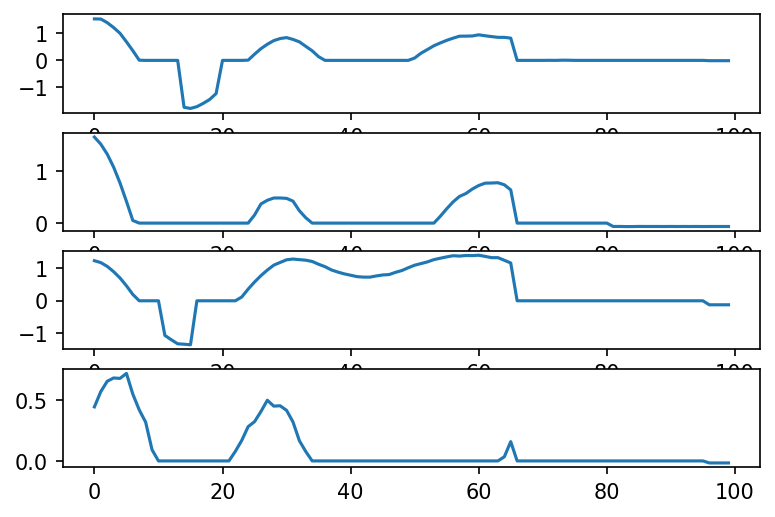

In [15]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(4,dpi=150)
axs[0].plot(x_train[100][:,0])
axs[1].plot(x_train[100][:,1])
axs[2].plot(x_train[100][:,2])
axs[3].plot(x_train[100][:,3])
plt.show()

In [4]:
print(d[0][0][0])
print(d[0][2][0])

tensor([ 0.3136, -0.1741,  1.5108, -1.8221, -1.0614,  2.0008, -0.5693, -1.1717,
        -0.4341, -1.4906,  0.0216,  0.1106, -0.6705, -1.2639,  0.1436, -0.3606,
         1.0504,  1.1009,  1.6793,  1.1948,  0.2880, -0.7602,  0.0716,  0.3777,
        -0.0271, -1.7038, -0.7959,  0.6043, -1.2405, -0.7648,  0.2068,  0.9863,
         0.4572, -0.2077, -0.0165, -0.9695,  1.1056,  0.7133,  0.3471, -1.5214,
        -0.2041,  0.7742,  0.2583,  0.9693,  0.9277,  0.8626,  0.4036, -0.4445,
         1.9301, -1.2494,  1.2357,  0.3332, -0.5465,  0.4880, -2.1216,  0.3777,
         0.0509,  2.1008, -0.7799, -0.2778,  0.4964,  1.5336, -1.5834, -0.2039,
        -1.1869, -0.8966,  0.6679, -0.7401, -0.2953, -0.4694, -1.4487,  0.4169,
        -0.0024, -0.0690,  0.2774,  0.3503, -0.7726, -1.9209,  0.0530,  1.3792,
        -2.0278, -0.5843,  0.5996, -1.4765,  0.5125,  1.9907,  1.6330,  0.3479,
        -1.8396,  1.4863,  1.1099,  0.0132,  0.2863, -0.1609,  0.1022,  0.0934],
       device='cuda:0')
tensor([ 0.2669

In [5]:
b[0]

tensor([60.6842, 64.9414, 68.5883, 72.0062, 65.4449, 71.7316, 66.9861, 77.8656,
        69.1223, 73.1049, 71.6705, 69.4275, 68.2983, 74.3103, 69.2444, 67.8558,
        62.4084, 73.7762, 69.0002, 69.0002, 65.5823, 68.1610, 76.0345, 66.4215,
        64.9872, 81.6193, 69.5190, 74.2188, 69.8242, 62.4390, 72.4945, 67.1692,
        61.4014, 68.1152, 67.0776, 64.2090, 73.9288, 70.8466, 65.0940, 73.1812,
        67.1387, 70.4041, 69.3359, 64.3768, 75.8972, 67.4286, 72.6166, 75.3174,
        69.1833, 69.2139, 72.9980, 69.3970, 69.0155, 65.2466, 69.4427, 81.4209,
        68.5730, 64.4226, 69.3665, 64.6210, 67.1234, 72.5098, 71.8231, 67.1234,
        68.0542, 62.2253, 66.2689, 72.5555, 72.7997, 61.9354, 71.0907, 68.8477,
        70.8466, 70.8771, 65.0024, 64.9414, 69.1833, 64.4073, 70.1447, 74.3866,
        69.6716, 66.4215, 69.4427, 62.2406, 62.5000, 64.5599, 70.1752, 68.3441,
        66.1469, 71.4569, 73.3337, 61.1572, 70.9839, 71.8842, 68.6798, 69.2444,
        72.4945, 71.0144, 72.6624, 79.45

In [6]:
c[0]

tensor([[69.3850],
        [73.4298],
        [65.5260],
        [78.0468],
        [70.4512],
        [74.9170],
        [79.5215],
        [70.1358],
        [68.7184],
        [71.6075],
        [71.2236],
        [70.4878],
        [71.1681],
        [72.1176],
        [63.8733],
        [72.2032],
        [85.0336],
        [66.5115],
        [69.0215],
        [71.1331],
        [69.0883],
        [69.2545],
        [68.0576],
        [76.2604],
        [70.2501],
        [69.4873],
        [75.9758],
        [70.1612],
        [75.4394],
        [77.6578],
        [66.6609],
        [70.1126],
        [75.5042],
        [73.1891],
        [68.9113],
        [75.7216],
        [73.9939],
        [74.6330],
        [72.6171],
        [76.1075],
        [74.2561],
        [72.9835],
        [72.3116],
        [73.8139],
        [72.9940],
        [76.0944],
        [69.5043],
        [68.6919],
        [77.2448],
        [83.8048],
        [68.9365],
        [77.0660],
        [70.

In [4]:
b[0]

tensor([73.0133, 61.7523, 70.2972, 62.0422, 66.0858, 71.7468, 59.7229, 66.6199,
        64.6515, 74.0814, 61.4014, 61.2946, 65.8264, 69.2902, 64.2090, 63.6902,
        60.3790, 65.6281, 61.0657, 61.7523, 66.6656, 69.2596, 67.5507, 63.8733,
        65.4297, 65.3839, 67.4438, 63.7970, 70.2820, 64.0259, 68.6340, 71.0144,
        65.2008, 62.9730, 64.3463, 68.0084, 64.7278, 61.3861, 58.6090, 64.1327,
        53.0090, 64.0869, 69.2291, 69.1528, 70.7855, 62.4237, 60.2264, 58.7006,
        59.7229, 74.9817, 67.2760, 72.3724, 61.9965, 64.9109, 69.2596, 73.9288,
        70.5872, 57.3730, 63.0341, 72.9523, 54.2145, 69.2902, 52.9480, 60.4095,
        57.3120, 61.1267, 60.8368, 64.5447, 66.5131, 80.7953, 62.0422, 62.4847,
        66.9098, 68.4509, 66.8640, 68.5730, 58.7006, 53.9703, 64.9567, 65.1245,
        69.1528, 64.4836, 67.3676, 58.1970, 62.4390, 66.5131, 52.9480, 70.2362,
        73.3643, 67.6117, 70.5872, 71.1212, 72.2809, 72.1283, 61.6302, 71.7468,
        63.3850, 58.0902, 56.9916, 69.80

In [5]:
c[0]

tensor([[66.7103],
        [65.1509],
        [65.1207],
        [66.8415],
        [66.3682],
        [65.9707],
        [66.4346],
        [66.6083],
        [66.5407],
        [66.6919],
        [66.5173],
        [66.5608],
        [66.7039],
        [66.2595],
        [66.5349],
        [66.6946],
        [66.7257],
        [66.7047],
        [65.3213],
        [66.5656],
        [66.6253],
        [66.5909],
        [65.7516],
        [66.6147],
        [66.7536],
        [66.4477],
        [66.7310],
        [66.6988],
        [66.7749],
        [66.6239],
        [66.8626],
        [66.5777],
        [66.7227],
        [66.5820],
        [65.5072],
        [66.7095],
        [66.5930],
        [66.5954],
        [66.5990],
        [66.6718],
        [66.6076],
        [66.6095],
        [66.7404],
        [66.6751],
        [66.7188],
        [66.6838],
        [66.6436],
        [66.5023],
        [66.7794],
        [66.6868],
        [66.8203],
        [66.6264],
        [66.

In [18]:
print(d[1][0][])
print(b[1][0])

torch.Size([100, 128])
tensor(70.7855, device='cuda:0')


In [15]:
print(d[1][1])
print(b[1][1])

tensor([[ 0.8435, -0.3027,  0.9783,  ..., -1.1749, -0.4841,  0.6483],
        [ 1.0568, -0.3862,  1.1517,  ..., -1.1805, -0.4875,  0.6479],
        [ 1.0792, -0.5794,  1.2346,  ..., -1.1830, -0.4816,  0.6580],
        ...,
        [ 1.0736, -0.6643,  0.9056,  ..., -1.1283, -0.4476,  0.7460],
        [ 0.8404, -0.7481,  0.7889,  ..., -1.1224, -0.4388,  0.7502],
        [ 0.7336, -0.6524,  0.7968,  ..., -1.1234, -0.4381,  0.7525]],
       device='cuda:0')
tensor(63.4308, device='cuda:0')


In [16]:
print(d[1][50])
print(b[1][50])

tensor([[ 0.8968, -0.2795,  0.9833,  ..., -1.1860, -0.5000,  0.6796],
        [ 1.1069, -0.3636,  1.1537,  ..., -1.1897, -0.4997,  0.6785],
        [ 1.1273, -0.5569,  1.2324,  ..., -1.1892, -0.4894,  0.6887],
        ...,
        [ 1.0688, -0.6581,  0.8749,  ..., -1.1148, -0.4525,  0.7457],
        [ 0.8348, -0.7427,  0.7582,  ..., -1.1091, -0.4419,  0.7502],
        [ 0.7273, -0.6467,  0.7658,  ..., -1.1098, -0.4398,  0.7515]],
       device='cuda:0')
tensor(67.6270, device='cuda:0')


In [17]:
print(d[0][100])
print(b[1][100])

tensor([[ 0.8735, -0.3011,  1.0025,  ..., -1.1863, -0.4848,  0.6605],
        [ 1.0865, -0.3860,  1.1745,  ..., -1.1927, -0.4849,  0.6587],
        [ 1.1067, -0.5816,  1.2544,  ..., -1.1948, -0.4754,  0.6676],
        ...,
        [ 1.0728, -0.6660,  0.9063,  ..., -1.1310, -0.4457,  0.7442],
        [ 0.8400, -0.7497,  0.7898,  ..., -1.1252, -0.4369,  0.7485],
        [ 0.7329, -0.6541,  0.7976,  ..., -1.1261, -0.4361,  0.7508]],
       device='cuda:0')
tensor(64.3311, device='cuda:0')


In [23]:
print(d[1][0][10])
print(d[1][100][10])

tensor([ 0.8439, -0.6626,  1.2917,  0.9123,  0.0023, -0.0434, -0.7994, -1.3684,
        -1.1958, -1.8966,  0.2213,  1.0023,  0.8817,  0.2169, -0.8540, -0.8513,
         1.0073, -0.1701, -0.6754, -0.5561,  1.2122, -0.0472, -0.7592, -1.1992,
        -2.1932, -0.0150, -1.6258,  0.8772,  0.0842, -0.3888,  0.5125, -1.0790,
        -0.1503,  1.5956, -0.5291, -0.5678,  1.4653, -1.1137,  1.6295,  1.5740,
         0.3217, -0.5893, -0.5859, -1.8044,  1.3807, -0.3081,  0.7100, -1.1297,
         1.2018, -1.4210, -0.1496,  0.4220,  1.7906, -0.0898,  1.5326,  1.1249,
         0.2791,  0.8360,  0.5875, -1.9181, -0.1300, -0.5012, -1.1189,  0.3740,
         0.2946, -1.2473, -1.9250,  0.0527, -1.8660,  1.3302,  0.3161,  1.3721,
         0.5537, -0.4978,  0.3031, -0.4098,  0.8516, -0.9263,  0.0218,  1.4811,
        -1.1935,  1.8934,  0.7669,  0.6211,  0.5737,  0.7605,  0.0679,  1.4109,
         0.8142,  1.6510,  0.2549, -0.8277,  1.0619, -1.7893, -0.0332,  1.4735,
        -0.7045, -0.8226, -0.6177, -0.09